# Abgeordnete (Stammdatenanalyse)

Kleine Auswertung von Abgeordnetenstammdaten aus dem Open-Data Portal des Bundestages.

* Import des xml-Files
* Datenaufbereitung, Einbeziehung zus. Features
* Datenanalyse / grafische Aufbereitung

## imports & variables

In [1]:
import requests
import zipfile
import os
import shutil
import pandas as pd
import xml.etree.ElementTree as et
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
folder_data = '../data'
folder_figures = '../figures'

file_download = 'mdb-stammdaten-data.zip'
file_xml = os.path.join(folder_data,'MDB_STAMMDATEN.XML')

## data prep

### data download & deflate to data folder

In [3]:
try:
    shutil.rmtree(folder_data)
except:
    pass
os.makedirs(folder_data)

In [4]:
url = 'https://www.bundestag.de/blob/472878/c1a07a64c9ea8c687df6634f2d9d805b/mdb-stammdaten-data.zip'
r = requests.get(url)
with open(os.path.join(folder_data, file_download), "wb") as data_zip:
    data_zip.write(r.content)

In [5]:
zip_ref = zipfile.ZipFile("../data/mdb-stammdaten-data.zip", 'r')
zip_ref.extractall("../data/")
zip_ref.close()

### parse xml and add relevant params to mdb_list

In [6]:
tree = et.parse(file_xml)  
root = tree.getroot()

In [7]:
mdb_list = []
for mdb in root[1:]:
    mdb_id =  mdb[0].text
    nachname = mdb[1][0][0].text
    vorname = mdb[1][0][1].text
    geburtsdatum = mdb[2][0].text
    geburtsort = mdb[2][1].text
    sterbedatum = mdb[2][3].text
    geschlecht_str = mdb[2][4].text
    familienstand = mdb[2][5].text
    religion = mdb[2][6].text
    beruf = mdb[2][7].text
    partei = mdb[2][8].text
    wahlperioden_anz = len(mdb[3])
    wahlperioden_list = []
    
    for wp in mdb[3]:
        wahlperioden_list.append(wp[0].text)
    
    mdb_values = (
        mdb_id, 
        nachname, 
        vorname, 
        geburtsdatum, 
        geburtsort, 
        sterbedatum, 
        geschlecht_str,
        familienstand,
        religion,
        beruf,
        partei,
        wahlperioden_anz,
        wahlperioden_list)
    
    mdb_list.append(mdb_values)

### mdb_list to dataframe

In [8]:
labels = [
    'mdb_id', 
    'nachname', 
    'vorname', 
    'geburtsdatum', 
    'geburtsort', 
    'sterbedatum', 
    'geschlecht_str',
    'familienstand',
    'religion',
    'beruf',
    'partei',
    'wahlperioden_anz',
    'wahlperioden_list'
    ]
df = pd.DataFrame.from_records(mdb_list, columns=labels)

### derived features

In [9]:
def geschlecht_bol (row):
    if row['geschlecht_str'] == u'männlich' :
        return True
    else:
        return False

df['geschlecht_m'] = df.apply (lambda row: geschlecht_bol (row),axis=1)

## data analysis

### overview

In [10]:
df.head()

,mdb_id,nachname,vorname,geburtsdatum,geburtsort,sterbedatum,geschlecht_str,familienstand,religion,beruf,partei,wahlperioden_anz,wahlperioden_list,geschlecht_m
0,11000001,Abelein,Manfred,20.10.1930,Stuttgart,17.01.2008,männlich,keine Angaben,katholisch,"Rechtsanwalt, Wirtschaftsprüfer, Universitätsp...",CDU,7,"[5, 6, 7, 8, 9, 10, 11]",True
1,11000002,Achenbach,Ernst,09.04.1909,Siegen,02.12.1991,männlich,"verheiratet, 3 Kinder",evangelisch,Rechtsanwalt und Notar,FDP,5,"[3, 4, 5, 6, 7]",True
2,11000003,Ackermann,Annemarie,26.05.1913,Parabutsch,18.02.1994,weiblich,"verheiratet, 5 Kinder",katholisch,Hilfsreferentin,CDU,3,"[2, 3, 4]",False
3,11000004,Ackermann,Else,06.11.1933,Berlin,None,weiblich,ledig,evangelisch,Ärztin,CDU,2,"[11, 12]",False
4,11000005,Adam,Ulrich,09.06.1950,"Teterow, Kr. Teterow, Bezirk Neubrandenburg",None,männlich,"verheiratet, 2 Kinder",evangelisch,"Mathematiker, Geschäftsführer",CDU,5,"[12, 13, 14, 15, 16]",True


In [11]:
profile = pandas_profiling.ProfileReport(df) 
profile.to_file(outputfile=os.path.join(folder_figures,'data_overview.html'))

### party frequency

In [12]:
df_party = df.groupby('partei')['mdb_id'].nunique().sort_values()

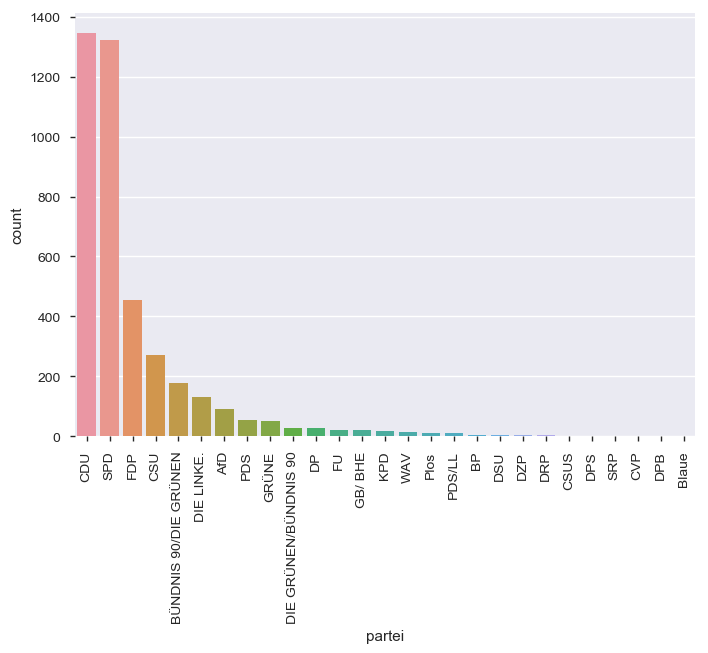

In [13]:
p = sns.countplot(data=df, x = 'partei', order = df['partei'].value_counts().index)
for item in p.get_xticklabels():
    item.set_rotation(90)
plt.show()

### sex frequency

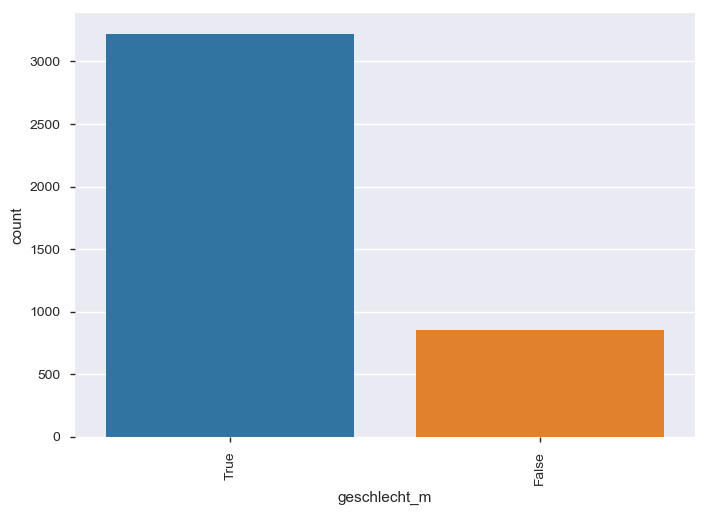

In [14]:
p = sns.countplot(data=df, x = 'geschlecht_m', order = df['geschlecht_m'].value_counts().index)
for item in p.get_xticklabels():
    item.set_rotation(90)
plt.show()

### religion frequency

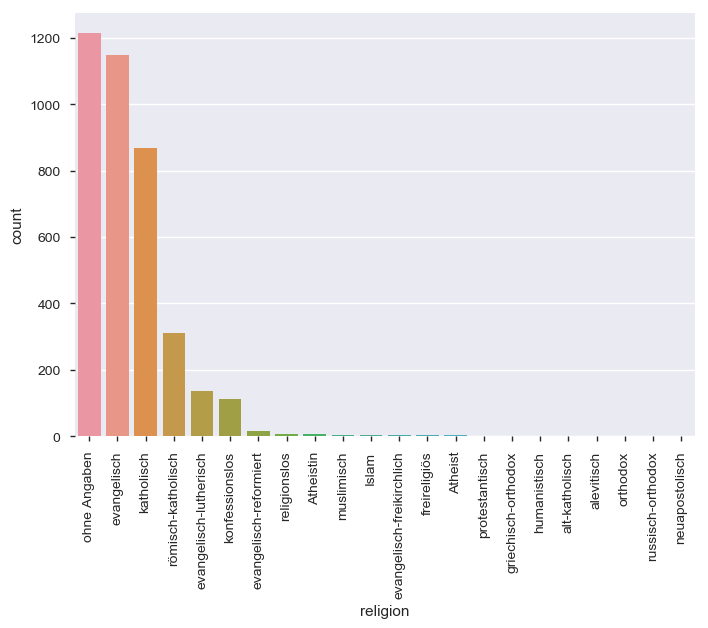

In [15]:
p = sns.countplot(data=df, x = 'religion', order = df['religion'].value_counts().index)
for item in p.get_xticklabels():
    item.set_rotation(90)
plt.show()

### wahlperioden frequency

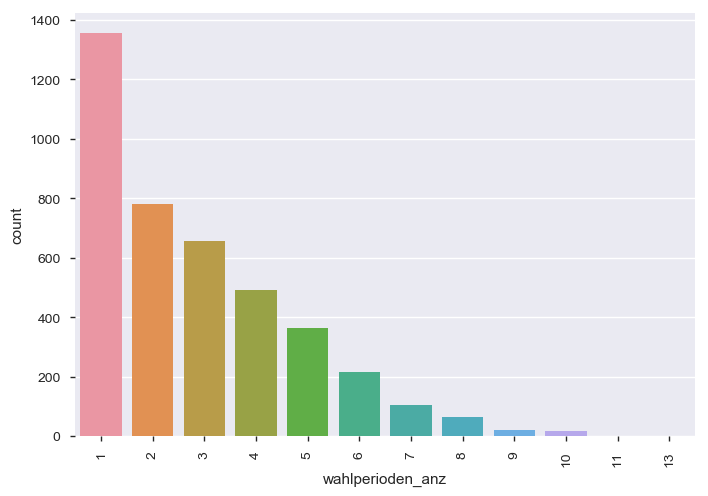

In [16]:
p = sns.countplot(data=df, x = 'wahlperioden_anz', order = df['wahlperioden_anz'].value_counts().index)
for item in p.get_xticklabels():
    item.set_rotation(90)
plt.show()